# 0) 라이브러리 버전, 데이터 확인

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!pip list | grep tensor

tensorboard                   2.7.0
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.0
tensorflow-addons             0.14.0
tensorflow-datasets           4.4.0
tensorflow-estimator          2.7.0
tensorflow-gpu                2.6.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.5.0


In [78]:
'''
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

SyntaxError: EOF while scanning triple-quoted string literal (3984398716.py, line 10)

In [5]:
'''
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


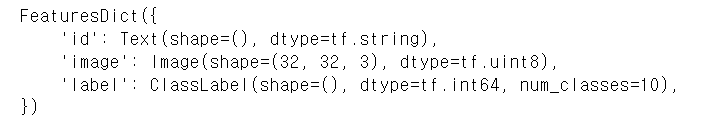

In [6]:
'''
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


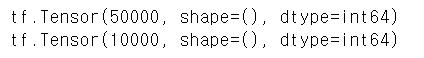

In [7]:
'''
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [8]:
'''
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
'''
ds_info.features["label"].num_classes

10

# 1) ResNet 기본 블록 구성하기
# ResNet-34, ResNet-50 Complete Model

In [46]:
'''
def build_resnet_basic_block(input_layer, channel, stride=1, block_num=1, block_idx=1):
    x = input_layer
    shortcut = input_layer

    # 첫 번째 Conv-BN-ReLU
    x = keras.layers.Conv2D(channel, (3,3), strides=stride, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'resblock{block_num}_{block_idx}_conv1')(x)
    x = keras.layers.BatchNormalization(name=f'resblock{block_num}_{block_idx}_bn1')(x)
    x = keras.layers.Activation('relu')(x)

    # 두 번째 Conv-BN
    x = keras.layers.Conv2D(channel, (3,3), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'resblock{block_num}_{block_idx}_conv2')(x)
    x = keras.layers.BatchNormalization(name=f'resblock{block_num}_{block_idx}_bn2')(x)

    # shortcut 처리
    if (input_layer.shape[-1] != channel) or (stride != 1):
        shortcut = keras.layers.Conv2D(channel, (1,1), strides=stride, padding='same', use_bias=False,
                                       kernel_initializer='he_normal', name=f'resblock{block_num}_{block_idx}_shortcut_conv')(shortcut)
        shortcut = keras.layers.BatchNormalization(name=f'resblock{block_num}_{block_idx}_shortcut_bn')(shortcut)

    x = keras.layers.Add(name=f'resblock{block_num}_{block_idx}_add')([x, shortcut])
    x = keras.layers.Activation('relu', name=f'resblock{block_num}_{block_idx}_out')(x)
    return x

In [47]:
'''
# 입력 레이어 생성
resnet_input_layer = keras.layers.Input(shape=(32, 32, 3))

resnet_block_output = build_resnet_block(
    resnet_input_layer,
    channel=64,
    block_num=1,
    stride=1,
    use_shortcut= True
)

# 블록 1개짜리 모델 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resblock1_conv0 (Conv2D)        (None, 32, 32, 64)   1728        input_18[0][0]                   
__________________________________________________________________________________________________
resblock1_bn0 (BatchNormalizati (None, 32, 32, 64)   256         resblock1_conv0[0][0]            
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 32, 32, 64)   0           resblock1_bn0[0][0]              
____________________________________________________________________________________________

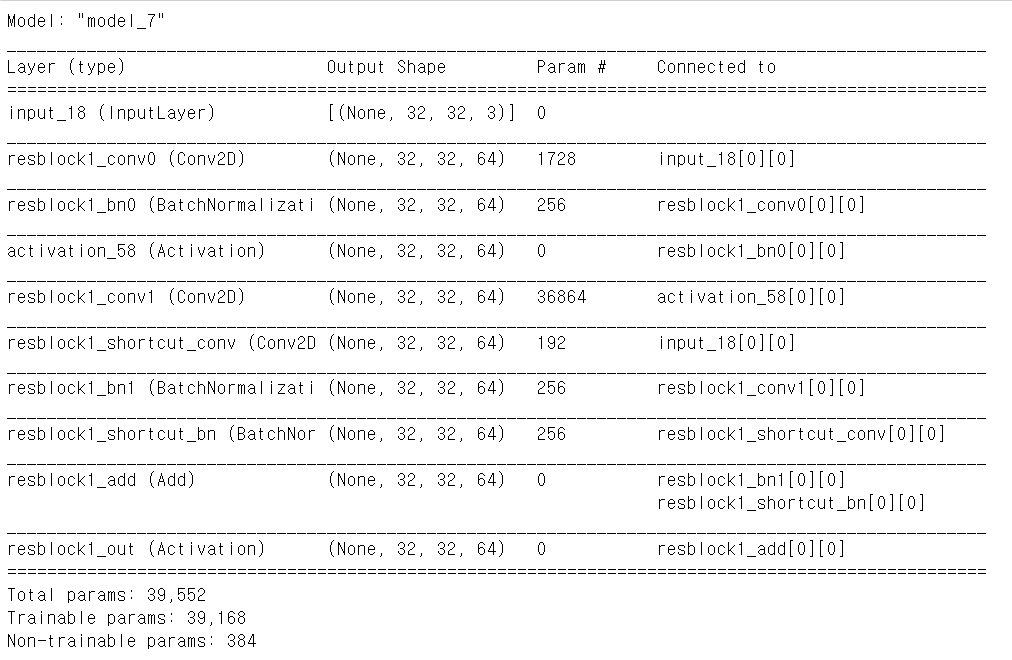

In [48]:
'''
def build_resnet_bottleneck_block(input_layer, channel, stride=1, block_num=1, block_idx=1):
    x = input_layer
    shortcut = input_layer

    # 1x1 Conv (감소)
    x = keras.layers.Conv2D(channel, (1,1), strides=stride, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv1')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn1')(x)
    x = keras.layers.Activation('relu')(x)

    # 3x3 Conv
    x = keras.layers.Conv2D(channel, (3,3), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv2')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn2')(x)
    x = keras.layers.Activation('relu')(x)

    # 1x1 Conv (증가)
    x = keras.layers.Conv2D(channel*4, (1,1), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv3')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn3')(x)

    # shortcut 처리
    if (input_layer.shape[-1] != channel*4) or (stride != 1):
        shortcut = keras.layers.Conv2D(channel*4, (1,1), strides=stride, padding='same', use_bias=False,
                                       kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_shortcut_conv')(shortcut)
        shortcut = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_shortcut_bn')(shortcut)

    x = keras.layers.Add(name=f'bottleneck{block_num}_{block_idx}_add')([x, shortcut])
    x = keras.layers.Activation('relu', name=f'bottleneck{block_num}_{block_idx}_out')(x)
    return x


In [53]:
'''
def build_resnet(input_shape=(32,32,3),
                 num_blocks_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 block_type='basic'):  # block_type 인자 추가
    assert len(num_blocks_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer

    # 초기 Conv-BN-ReLU
    x = keras.layers.Conv2D(64, (3,3), strides=1, padding='same', use_bias=False, kernel_initializer='he_normal', name='conv1')(x)
    x = keras.layers.BatchNormalization(name='bn1')(x)
    x = keras.layers.Activation('relu')(x)

    # residual blocks
    for block_num, (num_blocks, channel) in enumerate(zip(num_blocks_list, channel_list)):
        for block_idx in range(num_blocks):
            stride = 2 if (block_idx == 0 and block_num != 0) else 1
            if block_type == 'basic':
                x = build_resnet_basic_block(x, channel, stride=stride, block_num=block_num+1, block_idx=block_idx+1)
            elif block_type == 'bottleneck':
                x = build_resnet_bottleneck_block(x, channel, stride=stride, block_num=block_num+1, block_idx=block_idx+1)
            else:
                raise ValueError("block_type should be 'basic' or 'bottleneck'")

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=input_layer, outputs=x)
    return model


In [54]:
'''
resnet34 = build_resnet(block_type='basic')
resnet34.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1728        input_19[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 32, 32, 64)   0           bn1[0][0]                        
____________________________________________________________________________________________

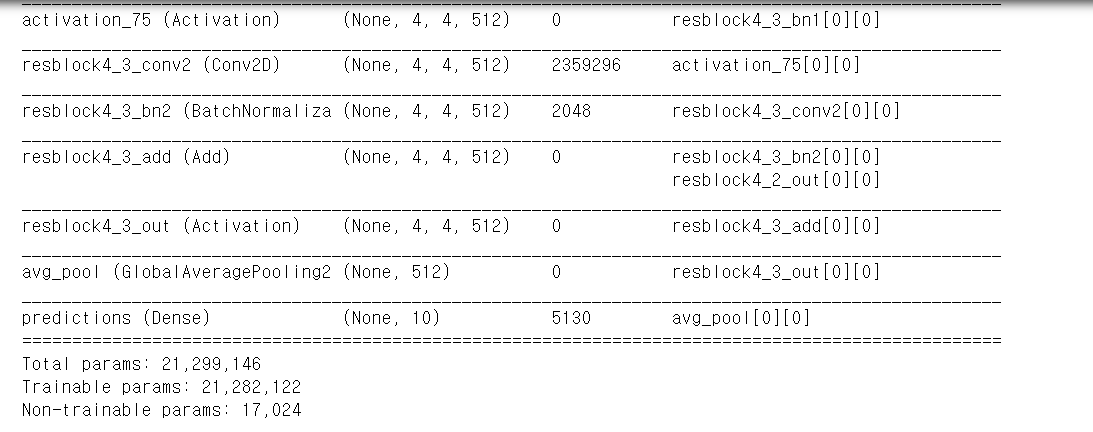

In [55]:
'''
resnet50 = build_resnet(block_type='bottleneck')
resnet50.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1728        input_20[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 32, 32, 64)   0           bn1[0][0]                        
____________________________________________________________________________________________

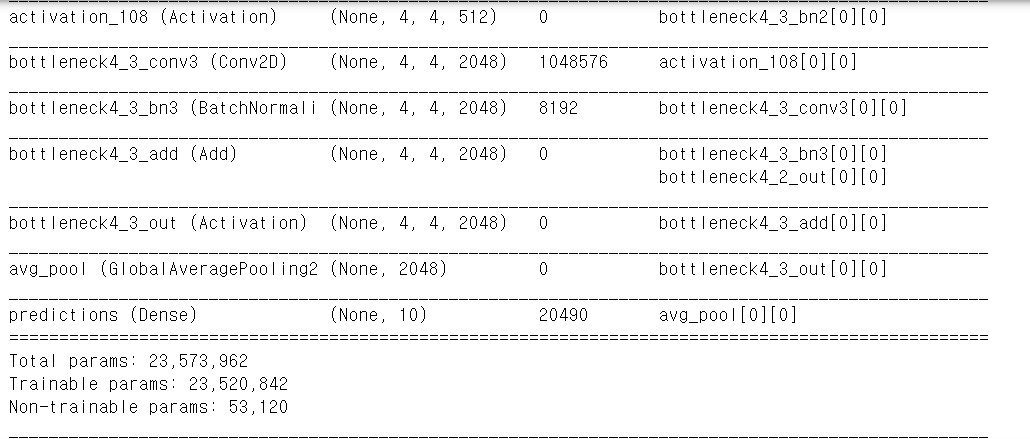

# 2) 일반 네트워크(plain network) 만들기

In [ ]:
#skip connection이 없는 블록
def build_resnet_basic_block(input_layer, channel, stride=1, block_num=1, block_idx=1, use_skip=True):
    x = input_layer
    shortcut = input_layer

    # 첫 번째 Conv-BN-ReLU
    x = keras.layers.Conv2D(channel, (3,3), strides=stride, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'resblock{block_num}_{block_idx}_conv1')(x)
    x = keras.layers.BatchNormalization(name=f'resblock{block_num}_{block_idx}_bn1')(x)
    x = keras.layers.Activation('relu')(x)

    # 두 번째 Conv-BN
    x = keras.layers.Conv2D(channel, (3,3), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'resblock{block_num}_{block_idx}_conv2')(x)
    x = keras.layers.BatchNormalization(name=f'resblock{block_num}_{block_idx}_bn2')(x)

    if use_skip:
        # shortcut 처리
        if (input_layer.shape[-1] != channel) or (stride != 1):
            shortcut = keras.layers.Conv2D(channel, (1,1), strides=stride, padding='same', use_bias=False,
                                           kernel_initializer='he_normal', name=f'resblock{block_num}_{block_idx}_shortcut_conv')(shortcut)
            shortcut = keras.layers.BatchNormalization(name=f'resblock{block_num}_{block_idx}_shortcut_bn')(shortcut)
        x = keras.layers.Add(name=f'resblock{block_num}_{block_idx}_add')([x, shortcut])

    x = keras.layers.Activation('relu', name=f'resblock{block_num}_{block_idx}_out')(x)
    return x

In [ ]:
#skip connection이 없는 블록
def build_resnet_bottleneck_block(input_layer, channel, stride=1, block_num=1, block_idx=1, use_skip=True):
    x = input_layer
    shortcut = input_layer

    # 1x1 Conv (감소)
    x = keras.layers.Conv2D(channel, (1,1), strides=stride, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv1')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn1')(x)
    x = keras.layers.Activation('relu')(x)

    # 3x3 Conv
    x = keras.layers.Conv2D(channel, (3,3), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv2')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn2')(x)
    x = keras.layers.Activation('relu')(x)

    # 1x1 Conv (증가)
    x = keras.layers.Conv2D(channel*4, (1,1), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv3')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn3')(x)

    if use_skip:
        if (input_layer.shape[-1] != channel*4) or (stride != 1):
            shortcut = keras.layers.Conv2D(channel*4, (1,1), strides=stride, padding='same', use_bias=False,
                                           kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_shortcut_conv')(shortcut)
            shortcut = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_shortcut_bn')(shortcut)
        x = keras.layers.Add(name=f'bottleneck{block_num}_{block_idx}_add')([x, shortcut])

    x = keras.layers.Activation('relu', name=f'bottleneck{block_num}_{block_idx}_out')(x)
    return x

In [ ]:
def build_resnet_or_plainnet(input_shape=(224,224,3),
                             num_blocks_list=[3,4,6,3],
                             channel_list=[64,128,256,512],
                             num_classes=1000,
                             block_type='basic',
                             use_skip=True):
    assert len(num_blocks_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer

    # Conv-BN-ReLU 
    x = keras.layers.Conv2D(64, (7,7), strides=2, padding='same', use_bias=False, kernel_initializer='he_normal', name='conv1')(x)
    x = keras.layers.BatchNormalization(name='bn1')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((3,3), strides=2, padding='same', name='maxpool')(x)

    for block_num, (num_blocks, channel) in enumerate(zip(num_blocks_list, channel_list)):
        for block_idx in range(num_blocks):
            stride = 2 if (block_idx == 0 and block_num != 0) else 1
            if block_type == 'basic':
                x = build_resnet_basic_block(x, channel, stride=stride, block_num=block_num+1, block_idx=block_idx+1, use_skip=use_skip)
            elif block_type == 'bottleneck':
                x = build_resnet_bottleneck_block(x, channel, stride=stride, block_num=block_num+1, block_idx=block_idx+1, use_skip=use_skip)
            else:
                raise ValueError("block_type should be 'basic' or 'bottleneck'")

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=input_layer, outputs=x)
    return model


In [60]:
# ResNet-34 (skip connection O)
resnet34 = build_resnet_or_plainnet(
    input_shape=(224,224,3),
    num_blocks_list=[3,4,6,3],
    channel_list=[64,128,256,512],
    num_classes=1000,
    block_type='basic',
    use_skip=True
)

resnet34.summary()


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        input_21[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 112, 112, 64) 0           bn1[0][0]                        
___________________________________________________________________________________________

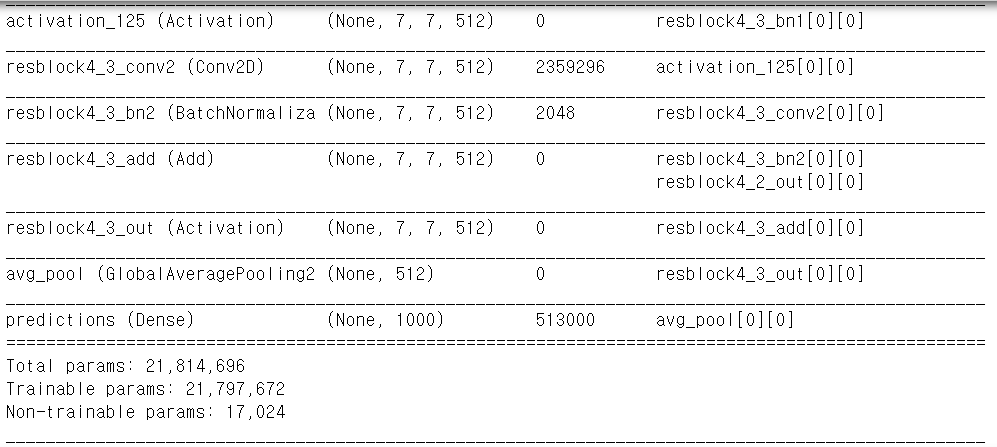

In [61]:
# PlainNet-34 (skip connection X)
plainnet34 = build_resnet_or_plainnet(
    input_shape=(224,224,3),
    num_blocks_list=[3,4,6,3],
    channel_list=[64,128,256,512],
    num_classes=1000,
    block_type='basic',
    use_skip=False
)
plainnet34.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9408      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 64)      256       
_________________________________________________________________
activation_126 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 56, 56, 64)        0         
_________________________________________________________________
resblock1_1_conv1 (Conv2D)   (None, 56, 56, 64)        36864     
_________________________________________________________________
resblock1_1_bn1 (BatchNormal (None, 56, 56, 64)        256

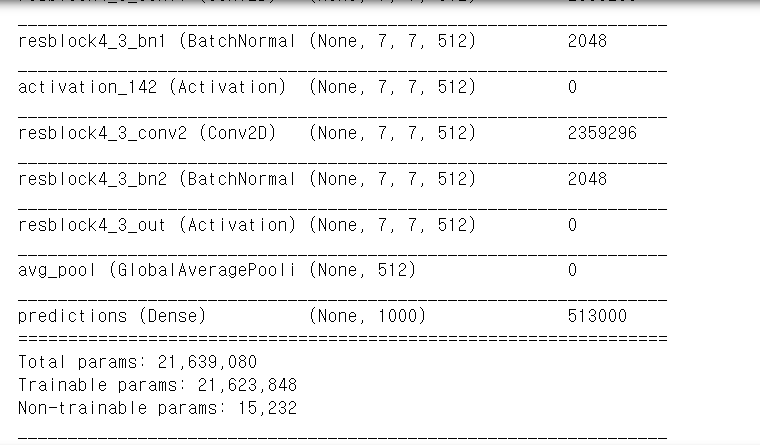

In [62]:
# ResNet-50 (bottleneck, skip connection O)
resnet50 = build_resnet_or_plainnet(
    input_shape=(224,224,3),
    num_blocks_list=[3,4,6,3],
    channel_list=[64,128,256,512],
    num_classes=1000,
    block_type='bottleneck',
    use_skip=True
)
resnet50.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        input_23[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_143 (Activation)     (None, 112, 112, 64) 0           bn1[0][0]                        
___________________________________________________________________________________________

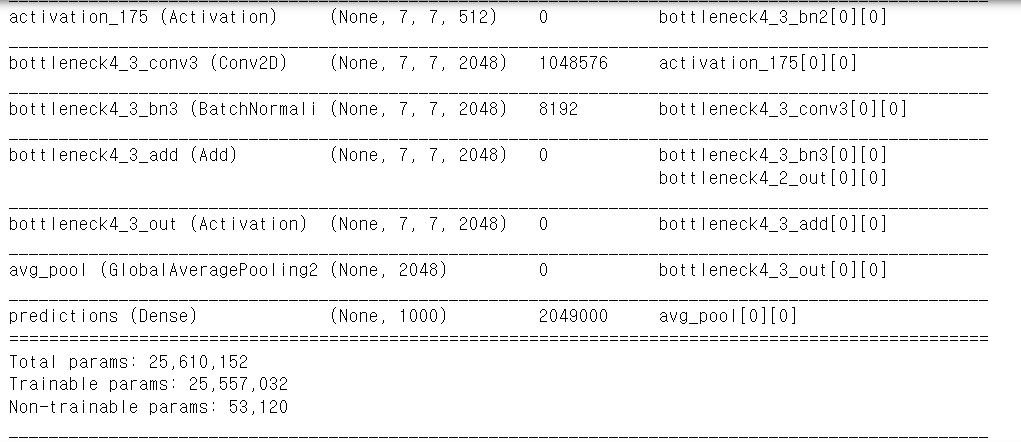

In [63]:
# PlainNet-50 (bottleneck, skip connection X)
plainnet50 = build_resnet_or_plainnet(
    input_shape=(224,224,3),
    num_blocks_list=[3,4,6,3],
    channel_list=[64,128,256,512],
    num_classes=1000,
    block_type='bottleneck',
    use_skip=False
)
plainnet50.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9408      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 64)      256       
_________________________________________________________________
activation_176 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 56, 56, 64)        0         
_________________________________________________________________
bottleneck1_1_conv1 (Conv2D) (None, 56, 56, 64)        4096      
_________________________________________________________________
bottleneck1_1_bn1 (BatchNorm (None, 56, 56, 64)        256

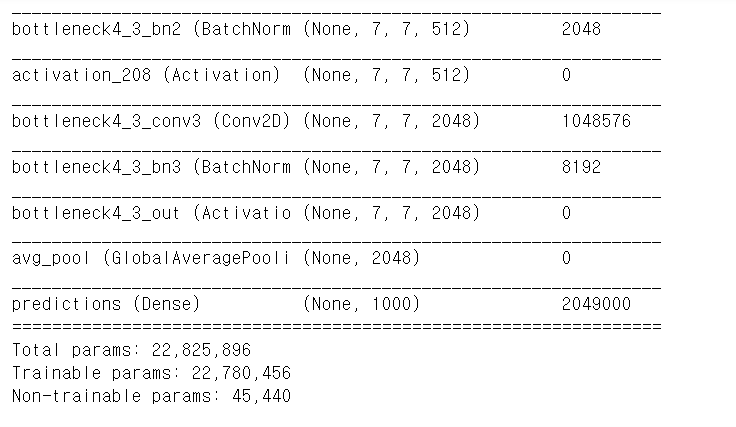

# 3) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
(cats_vs_dogs 데이터사용)

In [70]:
# URL변경으로 오류 처리
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
# 데이터셋 로드
train_ds, val_ds = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

# 전처리 함수
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 데이터셋 전처리 및 배치
BATCH_SIZE = 32

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [86]:
EPOCHS = 15

resnet50.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
plainnet50.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

print("Train ResNet-50")
history_resnet50 = resnet50.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

print("Train PlainNet-50")
history_plainnet50 = plainnet50.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Train ResNet-50
Epoch 1/15
164/582 [=======>......................] - ETA: 2:02 - loss: 0.4921 - accuracy: 0.7675

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:53 - loss: 0.4893 - accuracy: 0.7692

207/582 [=========>....................] - ETA: 1:50 - loss: 0.4903 - accuracy: 0.7672

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:29 - loss: 0.4779 - accuracy: 0.7749

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 28s - loss: 0.4432 - accuracy: 0.7927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 24s - loss: 0.4416 - accuracy: 0.7937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4415 - accuracy: 0.7938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4383 - accuracy: 0.7965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4379 - accuracy: 0.7968

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.7989

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 324ms/step - loss: 0.4324 - accuracy: 0.7989 - val_loss: 1.3598 - val_accuracy: 0.5750
Epoch 2/15
164/582 [=======>......................] - ETA: 2:11 - loss: 0.3296 - accuracy: 0.8565

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:00 - loss: 0.3293 - accuracy: 0.8545

207/582 [=========>....................] - ETA: 1:57 - loss: 0.3296 - accuracy: 0.8546

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:35 - loss: 0.3240 - accuracy: 0.8570

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.3137 - accuracy: 0.8649

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.3133 - accuracy: 0.8653

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.3125 - accuracy: 0.8659

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.3117 - accuracy: 0.8670

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.3105 - accuracy: 0.8676

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8685

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 197s 337ms/step - loss: 0.3086 - accuracy: 0.8685 - val_loss: 0.3615 - val_accuracy: 0.8343
Epoch 3/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.2683 - accuracy: 0.8841

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:02 - loss: 0.2664 - accuracy: 0.8844

207/582 [=========>....................] - ETA: 1:59 - loss: 0.2668 - accuracy: 0.8848

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.2581 - accuracy: 0.8894

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.2483 - accuracy: 0.8942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.2479 - accuracy: 0.8946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.2478 - accuracy: 0.8944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.2467 - accuracy: 0.8951

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.2464 - accuracy: 0.8950

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.8964

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 199s 341ms/step - loss: 0.2430 - accuracy: 0.8964 - val_loss: 0.6966 - val_accuracy: 0.7479
Epoch 4/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.2257 - accuracy: 0.9087

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.2185 - accuracy: 0.9120

207/582 [=========>....................] - ETA: 1:59 - loss: 0.2181 - accuracy: 0.9114

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.2116 - accuracy: 0.9131

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.2073 - accuracy: 0.9134

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.2076 - accuracy: 0.9132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.2069 - accuracy: 0.9140

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.2061 - accuracy: 0.9145

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.2054 - accuracy: 0.9149

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9151

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.2040 - accuracy: 0.9151 - val_loss: 0.2501 - val_accuracy: 0.8942
Epoch 5/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.1959 - accuracy: 0.9192

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.1930 - accuracy: 0.9207

207/582 [=========>....................] - ETA: 1:59 - loss: 0.1929 - accuracy: 0.9204

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.1919 - accuracy: 0.9182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1829 - accuracy: 0.9235

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1827 - accuracy: 0.9237

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1820 - accuracy: 0.9242

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1802 - accuracy: 0.9247

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1803 - accuracy: 0.9247

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9245

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.1817 - accuracy: 0.9245 - val_loss: 0.5253 - val_accuracy: 0.7257
Epoch 6/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.1552 - accuracy: 0.9362

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.1570 - accuracy: 0.9358

207/582 [=========>....................] - ETA: 1:59 - loss: 0.1570 - accuracy: 0.9358

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.1583 - accuracy: 0.9353

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1550 - accuracy: 0.9366

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1544 - accuracy: 0.9369

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1537 - accuracy: 0.9370

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1536 - accuracy: 0.9371

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1530 - accuracy: 0.9374

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9377

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.1524 - accuracy: 0.9377 - val_loss: 0.5440 - val_accuracy: 0.7889
Epoch 7/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.1397 - accuracy: 0.9430

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.1357 - accuracy: 0.9440

207/582 [=========>....................] - ETA: 1:59 - loss: 0.1340 - accuracy: 0.9441

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.1349 - accuracy: 0.9438

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1352 - accuracy: 0.9433

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1345 - accuracy: 0.9438

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1345 - accuracy: 0.9438

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1332 - accuracy: 0.9438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1332 - accuracy: 0.9438

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9445

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.1320 - accuracy: 0.9445 - val_loss: 0.2128 - val_accuracy: 0.9101
Epoch 8/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.1232 - accuracy: 0.9520

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.1221 - accuracy: 0.9510

207/582 [=========>....................] - ETA: 1:59 - loss: 0.1220 - accuracy: 0.9509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.1208 - accuracy: 0.9505

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1194 - accuracy: 0.9518

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1182 - accuracy: 0.9521

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1180 - accuracy: 0.9523

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1171 - accuracy: 0.9526

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1174 - accuracy: 0.9524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9534

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.1161 - accuracy: 0.9534 - val_loss: 0.2394 - val_accuracy: 0.9009
Epoch 9/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.0970 - accuracy: 0.9598

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:02 - loss: 0.0938 - accuracy: 0.9613

207/582 [=========>....................] - ETA: 1:59 - loss: 0.0945 - accuracy: 0.9611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.0931 - accuracy: 0.9611

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0970 - accuracy: 0.9606

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0968 - accuracy: 0.9606

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0960 - accuracy: 0.9611

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0956 - accuracy: 0.9614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0954 - accuracy: 0.9616

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9617

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 341ms/step - loss: 0.0965 - accuracy: 0.9617 - val_loss: 0.6417 - val_accuracy: 0.8291
Epoch 10/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.0904 - accuracy: 0.9651

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.0905 - accuracy: 0.9653

207/582 [=========>....................] - ETA: 1:59 - loss: 0.0900 - accuracy: 0.9654

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.0901 - accuracy: 0.9649

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0908 - accuracy: 0.9645

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0900 - accuracy: 0.9645

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0896 - accuracy: 0.9646

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0892 - accuracy: 0.9646

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0888 - accuracy: 0.9648

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9651

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.0883 - accuracy: 0.9651 - val_loss: 0.3159 - val_accuracy: 0.8852
Epoch 11/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.0896 - accuracy: 0.9625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.0857 - accuracy: 0.9637

207/582 [=========>....................] - ETA: 1:59 - loss: 0.0858 - accuracy: 0.9633

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.0884 - accuracy: 0.9616

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0882 - accuracy: 0.9636

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0874 - accuracy: 0.9638

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0871 - accuracy: 0.9637

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0861 - accuracy: 0.9643

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0855 - accuracy: 0.9646

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9655

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.0838 - accuracy: 0.9655 - val_loss: 0.3648 - val_accuracy: 0.8762
Epoch 12/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.0720 - accuracy: 0.9712

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:03 - loss: 0.0693 - accuracy: 0.9714

207/582 [=========>....................] - ETA: 1:59 - loss: 0.0694 - accuracy: 0.9713

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.0666 - accuracy: 0.9722

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0736 - accuracy: 0.9714

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0733 - accuracy: 0.9715

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0728 - accuracy: 0.9716

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0713 - accuracy: 0.9724

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0711 - accuracy: 0.9724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.9728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 341ms/step - loss: 0.0698 - accuracy: 0.9728 - val_loss: 0.2169 - val_accuracy: 0.9329
Epoch 13/15
164/582 [=======>......................] - ETA: 2:13 - loss: 0.0574 - accuracy: 0.9783

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:02 - loss: 0.0590 - accuracy: 0.9776

207/582 [=========>....................] - ETA: 1:59 - loss: 0.0603 - accuracy: 0.9772

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:36 - loss: 0.0664 - accuracy: 0.9751

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0628 - accuracy: 0.9761

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0626 - accuracy: 0.9762

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0623 - accuracy: 0.9764

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0619 - accuracy: 0.9764

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0620 - accuracy: 0.9763

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9764

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 341ms/step - loss: 0.0612 - accuracy: 0.9764 - val_loss: 0.3596 - val_accuracy: 0.8674
Epoch 14/15
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0539 - accuracy: 0.9809

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0532 - accuracy: 0.9819

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0531 - accuracy: 0.9816

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0587 - accuracy: 0.9797

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0551 - accuracy: 0.9796

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0548 - accuracy: 0.9796

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0543 - accuracy: 0.9798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0540 - accuracy: 0.9800

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0536 - accuracy: 0.9802

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9802

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 201s 345ms/step - loss: 0.0531 - accuracy: 0.9802 - val_loss: 0.3164 - val_accuracy: 0.9046
Epoch 15/15
164/582 [=======>......................] - ETA: 2:15 - loss: 0.0561 - accuracy: 0.9790

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0608 - accuracy: 0.9767

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0601 - accuracy: 0.9771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0565 - accuracy: 0.9786

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0534 - accuracy: 0.9793

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0530 - accuracy: 0.9793

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0528 - accuracy: 0.9793

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0527 - accuracy: 0.9791

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0532 - accuracy: 0.9790

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9796

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0523 - accuracy: 0.9796 - val_loss: 0.2985 - val_accuracy: 0.9162
Train PlainNet-50
Epoch 1/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.7024 - accuracy: 0.5345

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:41 - loss: 0.7030 - accuracy: 0.5327

207/582 [=========>....................] - ETA: 1:38 - loss: 0.7024 - accuracy: 0.5326

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.6985 - accuracy: 0.5411

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6978 - accuracy: 0.5312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6977 - accuracy: 0.5305

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6977 - accuracy: 0.5307

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6975 - accuracy: 0.5317

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6975 - accuracy: 0.5321 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5325

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 168s 282ms/step - loss: 0.6970 - accuracy: 0.5325 - val_loss: 0.7028 - val_accuracy: 0.5209
Epoch 2/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.6976 - accuracy: 0.5175

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6985 - accuracy: 0.5155

207/582 [=========>....................] - ETA: 1:38 - loss: 0.6985 - accuracy: 0.5145

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.6970 - accuracy: 0.5222

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6959 - accuracy: 0.5243

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6959 - accuracy: 0.5250

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6959 - accuracy: 0.5250

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6959 - accuracy: 0.5246

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6959 - accuracy: 0.5242 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5237

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 164s 280ms/step - loss: 0.6964 - accuracy: 0.5237 - val_loss: 0.7468 - val_accuracy: 0.4961
Epoch 3/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.7007 - accuracy: 0.5040

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6992 - accuracy: 0.5052

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6990 - accuracy: 0.5048

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.7005 - accuracy: 0.5058

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6994 - accuracy: 0.5059

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6993 - accuracy: 0.5050

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6992 - accuracy: 0.5046

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6991 - accuracy: 0.5052

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6989 - accuracy: 0.5055 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.5048

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 279ms/step - loss: 0.6992 - accuracy: 0.5048 - val_loss: 0.8134 - val_accuracy: 0.4929
Epoch 4/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.6936 - accuracy: 0.5261

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6923 - accuracy: 0.5308

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6926 - accuracy: 0.5293

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.6920 - accuracy: 0.5300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6931 - accuracy: 0.5249

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6930 - accuracy: 0.5254

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6934 - accuracy: 0.5242

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6936 - accuracy: 0.5229

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6936 - accuracy: 0.5223 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5198

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 279ms/step - loss: 0.6941 - accuracy: 0.5198 - val_loss: 0.6970 - val_accuracy: 0.4901
Epoch 5/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.6969 - accuracy: 0.5103

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6968 - accuracy: 0.5095

207/582 [=========>....................] - ETA: 1:38 - loss: 0.6966 - accuracy: 0.5097

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.6969 - accuracy: 0.5102

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6968 - accuracy: 0.5146

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6968 - accuracy: 0.5141

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6968 - accuracy: 0.5142

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6969 - accuracy: 0.5150

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6968 - accuracy: 0.5152 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.5156

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 164s 280ms/step - loss: 0.6966 - accuracy: 0.5156 - val_loss: 0.6993 - val_accuracy: 0.5060
Epoch 6/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.6952 - accuracy: 0.5160

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6951 - accuracy: 0.5170

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6953 - accuracy: 0.5160

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.6955 - accuracy: 0.5179

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6957 - accuracy: 0.5196

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6957 - accuracy: 0.5187

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6957 - accuracy: 0.5177

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6958 - accuracy: 0.5175

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6956 - accuracy: 0.5178 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 279ms/step - loss: 0.6955 - accuracy: 0.5181 - val_loss: 0.7003 - val_accuracy: 0.4895
Epoch 7/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6951 - accuracy: 0.5078

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6952 - accuracy: 0.5063

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6951 - accuracy: 0.5066

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6954 - accuracy: 0.5068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6953 - accuracy: 0.5131

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6956 - accuracy: 0.5122

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6955 - accuracy: 0.5126

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6956 - accuracy: 0.5114

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6954 - accuracy: 0.5121 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5119

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 278ms/step - loss: 0.6955 - accuracy: 0.5119 - val_loss: 0.7210 - val_accuracy: 0.5275
Epoch 8/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6889 - accuracy: 0.5459

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:39 - loss: 0.6906 - accuracy: 0.5371

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6908 - accuracy: 0.5356

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6909 - accuracy: 0.5346

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6894 - accuracy: 0.5406

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6892 - accuracy: 0.5413

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6893 - accuracy: 0.5407

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6892 - accuracy: 0.5413

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6892 - accuracy: 0.5412 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5425

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 278ms/step - loss: 0.6890 - accuracy: 0.5425 - val_loss: 0.6934 - val_accuracy: 0.5593
Epoch 9/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6888 - accuracy: 0.5377

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6901 - accuracy: 0.5351

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6906 - accuracy: 0.5328

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6921 - accuracy: 0.5277

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6903 - accuracy: 0.5373

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6899 - accuracy: 0.5375

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6899 - accuracy: 0.5382

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6897 - accuracy: 0.5385

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6893 - accuracy: 0.5387 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5395

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 278ms/step - loss: 0.6894 - accuracy: 0.5395 - val_loss: 0.6880 - val_accuracy: 0.5469
Epoch 10/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6827 - accuracy: 0.5593

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:39 - loss: 0.6839 - accuracy: 0.5592

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6840 - accuracy: 0.5596

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6840 - accuracy: 0.5609

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6844 - accuracy: 0.5585

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6846 - accuracy: 0.5587

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6849 - accuracy: 0.5578

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6844 - accuracy: 0.5579

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6846 - accuracy: 0.5578 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.5576

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 277ms/step - loss: 0.6849 - accuracy: 0.5576 - val_loss: 0.6795 - val_accuracy: 0.5765
Epoch 11/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6832 - accuracy: 0.5602

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:39 - loss: 0.6839 - accuracy: 0.5566

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6838 - accuracy: 0.5569

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6839 - accuracy: 0.5603

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6840 - accuracy: 0.5618

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6839 - accuracy: 0.5623

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6838 - accuracy: 0.5622

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6833 - accuracy: 0.5621

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6829 - accuracy: 0.5625 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 277ms/step - loss: 0.6833 - accuracy: 0.5620 - val_loss: 0.7227 - val_accuracy: 0.5716
Epoch 12/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6825 - accuracy: 0.5621

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:39 - loss: 0.6826 - accuracy: 0.5642

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6838 - accuracy: 0.5604

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6829 - accuracy: 0.5609

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6809 - accuracy: 0.5649

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6811 - accuracy: 0.5647

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6810 - accuracy: 0.5651

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6809 - accuracy: 0.5656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6806 - accuracy: 0.5665 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.5667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 278ms/step - loss: 0.6806 - accuracy: 0.5667 - val_loss: 0.6798 - val_accuracy: 0.5789
Epoch 13/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6939 - accuracy: 0.5179

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6916 - accuracy: 0.5259

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6909 - accuracy: 0.5282

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6877 - accuracy: 0.5417

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6877 - accuracy: 0.5432

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6878 - accuracy: 0.5431

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6879 - accuracy: 0.5426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6881 - accuracy: 0.5426

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6880 - accuracy: 0.5433 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.5446

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 279ms/step - loss: 0.6876 - accuracy: 0.5446 - val_loss: 0.6786 - val_accuracy: 0.5716
Epoch 14/15
164/582 [=======>......................] - ETA: 1:48 - loss: 0.6861 - accuracy: 0.5581

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6870 - accuracy: 0.5593

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6873 - accuracy: 0.5577

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:18 - loss: 0.6858 - accuracy: 0.5606

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6871 - accuracy: 0.5564

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6871 - accuracy: 0.5566

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6870 - accuracy: 0.5567

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6874 - accuracy: 0.5563

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6874 - accuracy: 0.5560 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5576

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 278ms/step - loss: 0.6871 - accuracy: 0.5576 - val_loss: 0.7056 - val_accuracy: 0.5224
Epoch 15/15
164/582 [=======>......................] - ETA: 1:49 - loss: 0.6758 - accuracy: 0.5810

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:40 - loss: 0.6775 - accuracy: 0.5758

207/582 [=========>....................] - ETA: 1:37 - loss: 0.6779 - accuracy: 0.5740

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:19 - loss: 0.6790 - accuracy: 0.5705

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 24s - loss: 0.6783 - accuracy: 0.5717

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6784 - accuracy: 0.5717

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6784 - accuracy: 0.5716

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6783 - accuracy: 0.5711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 9s - loss: 0.6781 - accuracy: 0.5713 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.5708

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 163s 279ms/step - loss: 0.6783 - accuracy: 0.5708 - val_loss: 0.7046 - val_accuracy: 0.4994


epoch:3
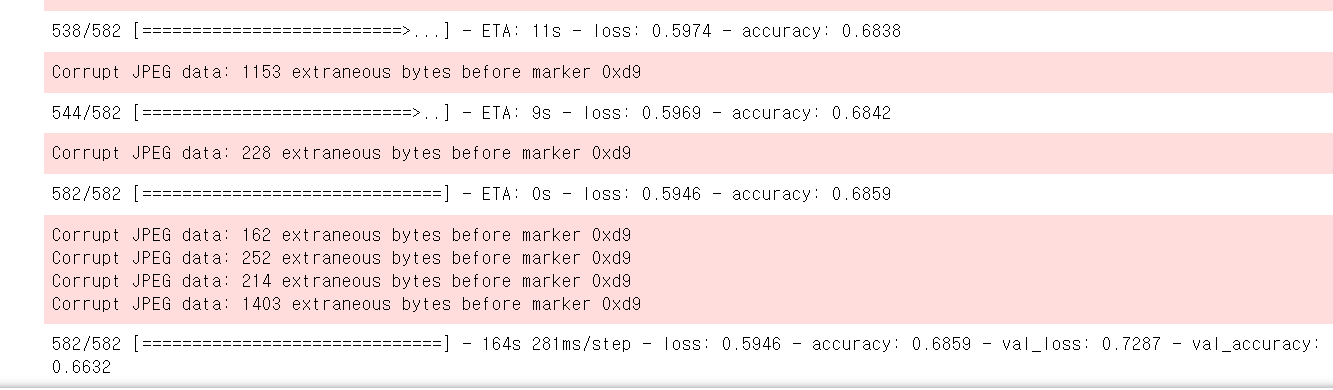
epoch:15
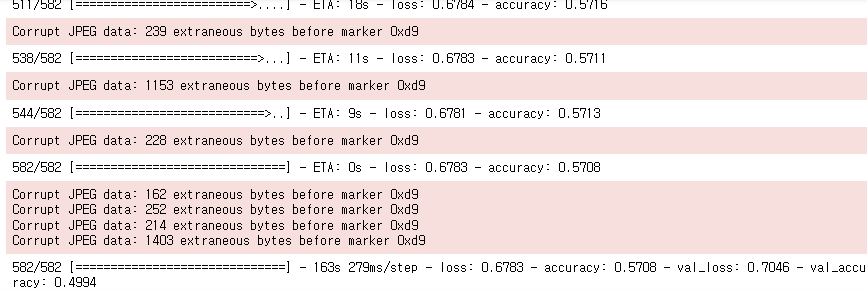

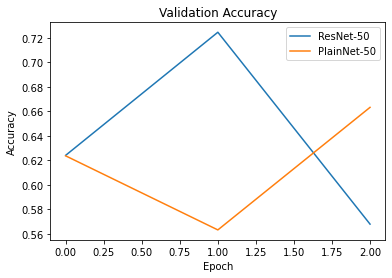

In [72]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50.history['val_accuracy'], label='ResNet-50')
plt.plot(history_plainnet50.history['val_accuracy'], label='PlainNet-50')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


epoch:3
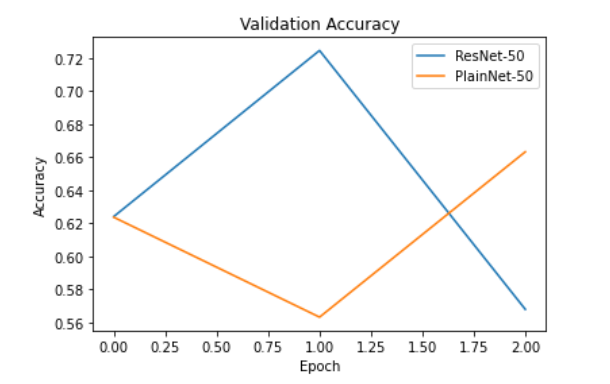

In [87]:
EPOCHS = 15

resnet34.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
plainnet34.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

print("Train ResNet-34")
history_resnet34 = resnet34.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

print("Train PlainNet-34")
history_plainnet34 = plainnet34.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Train ResNet-34
Epoch 1/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.3628 - accuracy: 0.8413

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.3570 - accuracy: 0.8426

208/582 [=========>....................] - ETA: 1:06 - loss: 0.3547 - accuracy: 0.8436

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.3455 - accuracy: 0.8477

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3246 - accuracy: 0.8574

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.3226 - accuracy: 0.8586

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.3211 - accuracy: 0.8593

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3197 - accuracy: 0.8598

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3188 - accuracy: 0.8603

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8604

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 115s 192ms/step - loss: 0.3166 - accuracy: 0.8604 - val_loss: 0.4098 - val_accuracy: 0.8263
Epoch 2/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2684 - accuracy: 0.8792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2608 - accuracy: 0.8843

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2603 - accuracy: 0.8852

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.2574 - accuracy: 0.8881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.2459 - accuracy: 0.8940

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.2450 - accuracy: 0.8943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.2446 - accuracy: 0.8945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2440 - accuracy: 0.8948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2442 - accuracy: 0.8949

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.8958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.2421 - accuracy: 0.8958 - val_loss: 0.2285 - val_accuracy: 0.9046
Epoch 3/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2105 - accuracy: 0.9146

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2021 - accuracy: 0.9173

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2064 - accuracy: 0.9156

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.2061 - accuracy: 0.9144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1991 - accuracy: 0.9176

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1989 - accuracy: 0.9176

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1997 - accuracy: 0.9171

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1995 - accuracy: 0.9165

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1994 - accuracy: 0.9163

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9174

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.1980 - accuracy: 0.9174 - val_loss: 1.0632 - val_accuracy: 0.7513
Epoch 4/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1806 - accuracy: 0.9254

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1783 - accuracy: 0.9260

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1768 - accuracy: 0.9268

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1744 - accuracy: 0.9282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1695 - accuracy: 0.9311

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1690 - accuracy: 0.9312

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1684 - accuracy: 0.9313

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1674 - accuracy: 0.9311

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1677 - accuracy: 0.9308

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9311

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.1674 - accuracy: 0.9311 - val_loss: 0.4602 - val_accuracy: 0.7646
Epoch 5/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1511 - accuracy: 0.9375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1515 - accuracy: 0.9386

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1491 - accuracy: 0.9398

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1540 - accuracy: 0.9388

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1541 - accuracy: 0.9381

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1543 - accuracy: 0.9381

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1534 - accuracy: 0.9384

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1501 - accuracy: 0.9394

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1493 - accuracy: 0.9397

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9404

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 192ms/step - loss: 0.1481 - accuracy: 0.9404 - val_loss: 0.1942 - val_accuracy: 0.9196
Epoch 6/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1299 - accuracy: 0.9475

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1286 - accuracy: 0.9489

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1283 - accuracy: 0.9488

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1298 - accuracy: 0.9488

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1265 - accuracy: 0.9501

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1259 - accuracy: 0.9503

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1256 - accuracy: 0.9505

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1240 - accuracy: 0.9511

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1236 - accuracy: 0.9512

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9510

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 192ms/step - loss: 0.1230 - accuracy: 0.9510 - val_loss: 0.2638 - val_accuracy: 0.9024
Epoch 7/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1131 - accuracy: 0.9538

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1165 - accuracy: 0.9522

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1175 - accuracy: 0.9513

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1160 - accuracy: 0.9525

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1141 - accuracy: 0.9532

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1139 - accuracy: 0.9531

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1132 - accuracy: 0.9534

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1128 - accuracy: 0.9535

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1126 - accuracy: 0.9534

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9536

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.1114 - accuracy: 0.9536 - val_loss: 0.2034 - val_accuracy: 0.9056
Epoch 8/15
165/582 [=======>......................] - ETA: 1:15 - loss: 0.1043 - accuracy: 0.9572

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:09 - loss: 0.1043 - accuracy: 0.9568

208/582 [=========>....................] - ETA: 1:07 - loss: 0.1024 - accuracy: 0.9575

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.1002 - accuracy: 0.9583

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1009 - accuracy: 0.9591

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1007 - accuracy: 0.9593

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1002 - accuracy: 0.9594

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0991 - accuracy: 0.9601

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0992 - accuracy: 0.9599

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9610

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 194ms/step - loss: 0.0967 - accuracy: 0.9610 - val_loss: 0.2141 - val_accuracy: 0.9226
Epoch 9/15
165/582 [=======>......................] - ETA: 1:15 - loss: 0.0831 - accuracy: 0.9676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:09 - loss: 0.0808 - accuracy: 0.9688

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0813 - accuracy: 0.9686

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0825 - accuracy: 0.9674

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 17s - loss: 0.0796 - accuracy: 0.9682

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0794 - accuracy: 0.9681

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0793 - accuracy: 0.9681

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0799 - accuracy: 0.9677

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0800 - accuracy: 0.9678

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9674

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 194ms/step - loss: 0.0810 - accuracy: 0.9674 - val_loss: 0.2034 - val_accuracy: 0.9181
Epoch 10/15
165/582 [=======>......................] - ETA: 1:15 - loss: 0.0649 - accuracy: 0.9750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:09 - loss: 0.0626 - accuracy: 0.9754

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0642 - accuracy: 0.9746

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0753 - accuracy: 0.9701

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 17s - loss: 0.0692 - accuracy: 0.9730

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0684 - accuracy: 0.9734

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0684 - accuracy: 0.9734

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0672 - accuracy: 0.9740

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0669 - accuracy: 0.9741

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9740

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 194ms/step - loss: 0.0670 - accuracy: 0.9740 - val_loss: 0.3200 - val_accuracy: 0.8966
Epoch 11/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0615 - accuracy: 0.9739

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0652 - accuracy: 0.9729

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0649 - accuracy: 0.9728

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0699 - accuracy: 0.9710

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0647 - accuracy: 0.9744

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0641 - accuracy: 0.9746

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0644 - accuracy: 0.9746

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0630 - accuracy: 0.9752

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0626 - accuracy: 0.9755

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9760

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0613 - accuracy: 0.9760 - val_loss: 0.3432 - val_accuracy: 0.8828
Epoch 12/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0523 - accuracy: 0.9805

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0541 - accuracy: 0.9800

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0533 - accuracy: 0.9802

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0541 - accuracy: 0.9791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0520 - accuracy: 0.9802

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0523 - accuracy: 0.9802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0527 - accuracy: 0.9800

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0529 - accuracy: 0.9799

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0531 - accuracy: 0.9798

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9795

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 115s 196ms/step - loss: 0.0534 - accuracy: 0.9795 - val_loss: 0.2438 - val_accuracy: 0.9269
Epoch 13/15
165/582 [=======>......................] - ETA: 1:13 - loss: 0.0483 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0470 - accuracy: 0.9830

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0462 - accuracy: 0.9832

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0420 - accuracy: 0.9847

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0441 - accuracy: 0.9844

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0441 - accuracy: 0.9844

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0441 - accuracy: 0.9844

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0431 - accuracy: 0.9846

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0432 - accuracy: 0.9845

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9843

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0437 - accuracy: 0.9843 - val_loss: 1.8962 - val_accuracy: 0.6735
Epoch 14/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0464 - accuracy: 0.9820

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0427 - accuracy: 0.9834

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0410 - accuracy: 0.9842

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0360 - accuracy: 0.9862

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0379 - accuracy: 0.9863

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0375 - accuracy: 0.9863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0373 - accuracy: 0.9864

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0367 - accuracy: 0.9867

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0365 - accuracy: 0.9869

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9873

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.2285 - val_accuracy: 0.9325
Epoch 15/15
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0286 - accuracy: 0.9886

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0321 - accuracy: 0.9877

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0322 - accuracy: 0.9878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0327 - accuracy: 0.9883

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0360 - accuracy: 0.9866

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0363 - accuracy: 0.9863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0364 - accuracy: 0.9863

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0358 - accuracy: 0.9864

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0355 - accuracy: 0.9865

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9867

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0347 - accuracy: 0.9867 - val_loss: 0.2071 - val_accuracy: 0.9405
Train PlainNet-34
Epoch 1/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6974 - accuracy: 0.5261

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6965 - accuracy: 0.5297

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6968 - accuracy: 0.5273

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6982 - accuracy: 0.5189

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6934 - accuracy: 0.5296

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6931 - accuracy: 0.5299

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6930 - accuracy: 0.5300

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6923 - accuracy: 0.5328

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6923 - accuracy: 0.5334

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5354

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 182ms/step - loss: 0.6918 - accuracy: 0.5354 - val_loss: 0.6844 - val_accuracy: 0.5671
Epoch 2/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6844 - accuracy: 0.5585

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6839 - accuracy: 0.5557

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6826 - accuracy: 0.5575

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6790 - accuracy: 0.5581

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6745 - accuracy: 0.5673

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6732 - accuracy: 0.5697

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6733 - accuracy: 0.5700

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6732 - accuracy: 0.5711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6731 - accuracy: 0.5714

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.5722

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.6723 - accuracy: 0.5722 - val_loss: 1.0424 - val_accuracy: 0.5868
Epoch 3/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6491 - accuracy: 0.6239

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6467 - accuracy: 0.6264

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6471 - accuracy: 0.6255

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6482 - accuracy: 0.6202

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6479 - accuracy: 0.6179

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6472 - accuracy: 0.6184

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6466 - accuracy: 0.6189

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6462 - accuracy: 0.6198

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6462 - accuracy: 0.6200

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.6202

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6464 - accuracy: 0.6202 - val_loss: 1.0768 - val_accuracy: 0.5348
Epoch 4/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6535 - accuracy: 0.6163

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6507 - accuracy: 0.6198

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6494 - accuracy: 0.6209

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6471 - accuracy: 0.6204

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6437 - accuracy: 0.6246

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6433 - accuracy: 0.6255

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6424 - accuracy: 0.6267

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6424 - accuracy: 0.6262

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6423 - accuracy: 0.6263

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.6280

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6412 - accuracy: 0.6280 - val_loss: 0.6629 - val_accuracy: 0.6227
Epoch 5/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6229 - accuracy: 0.6561

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6231 - accuracy: 0.6555

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6228 - accuracy: 0.6564

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6260 - accuracy: 0.6530

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6191 - accuracy: 0.6596

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6187 - accuracy: 0.6601

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6184 - accuracy: 0.6606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6179 - accuracy: 0.6609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6175 - accuracy: 0.6610

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.6606

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6182 - accuracy: 0.6606 - val_loss: 0.7780 - val_accuracy: 0.5247
Epoch 6/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5971 - accuracy: 0.6797

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5956 - accuracy: 0.6824

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5954 - accuracy: 0.6843

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5962 - accuracy: 0.6842

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5904 - accuracy: 0.6906

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5907 - accuracy: 0.6898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5895 - accuracy: 0.6907

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5881 - accuracy: 0.6923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5883 - accuracy: 0.6921

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.6922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5875 - accuracy: 0.6922 - val_loss: 0.6852 - val_accuracy: 0.6623
Epoch 7/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5598 - accuracy: 0.7127

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5624 - accuracy: 0.7104

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5637 - accuracy: 0.7102

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5675 - accuracy: 0.7023

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5641 - accuracy: 0.7084

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5631 - accuracy: 0.7090

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5628 - accuracy: 0.7090

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5625 - accuracy: 0.7094

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5620 - accuracy: 0.7101

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7097

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5621 - accuracy: 0.7097 - val_loss: 0.7794 - val_accuracy: 0.6758
Epoch 8/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5372 - accuracy: 0.7286

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5393 - accuracy: 0.7268

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5386 - accuracy: 0.7284

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5383 - accuracy: 0.7283

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5341 - accuracy: 0.7332

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5341 - accuracy: 0.7328

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5343 - accuracy: 0.7323

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5347 - accuracy: 0.7317

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5344 - accuracy: 0.7319

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.7313

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5347 - accuracy: 0.7313 - val_loss: 0.8156 - val_accuracy: 0.6062
Epoch 9/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5113 - accuracy: 0.7468

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5115 - accuracy: 0.7484

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5118 - accuracy: 0.7479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5076 - accuracy: 0.7515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5032 - accuracy: 0.7570

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5025 - accuracy: 0.7572

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5011 - accuracy: 0.7582

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5000 - accuracy: 0.7590

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5006 - accuracy: 0.7583

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.7591

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.4993 - accuracy: 0.7591 - val_loss: 0.6266 - val_accuracy: 0.7087
Epoch 10/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4789 - accuracy: 0.7775

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4724 - accuracy: 0.7822

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4734 - accuracy: 0.7825

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4702 - accuracy: 0.7827

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4623 - accuracy: 0.7851

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4619 - accuracy: 0.7858

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4606 - accuracy: 0.7864

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4583 - accuracy: 0.7878

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4579 - accuracy: 0.7881

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7876

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.4579 - accuracy: 0.7876 - val_loss: 1.0628 - val_accuracy: 0.6258
Epoch 11/15
165/582 [=======>......................] - ETA: 1:11 - loss: 0.4326 - accuracy: 0.8064

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4338 - accuracy: 0.8068

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4337 - accuracy: 0.8069

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4275 - accuracy: 0.8088

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.4226 - accuracy: 0.8107

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4221 - accuracy: 0.8113

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4229 - accuracy: 0.8107

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4219 - accuracy: 0.8109

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4222 - accuracy: 0.8109

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8121

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.4200 - accuracy: 0.8121 - val_loss: 0.4817 - val_accuracy: 0.7992
Epoch 12/15
165/582 [=======>......................] - ETA: 1:11 - loss: 0.3885 - accuracy: 0.8277

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3893 - accuracy: 0.8278

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3877 - accuracy: 0.8289

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3891 - accuracy: 0.8299

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3867 - accuracy: 0.8286

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3864 - accuracy: 0.8288

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3861 - accuracy: 0.8289

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3847 - accuracy: 0.8289

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3841 - accuracy: 0.8291

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8294

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3844 - accuracy: 0.8294 - val_loss: 0.8796 - val_accuracy: 0.6094
Epoch 13/15
165/582 [=======>......................] - ETA: 1:10 - loss: 0.3721 - accuracy: 0.8290

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3729 - accuracy: 0.8314

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3738 - accuracy: 0.8308

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3723 - accuracy: 0.8320

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3667 - accuracy: 0.8391

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3664 - accuracy: 0.8393

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3655 - accuracy: 0.8393

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3643 - accuracy: 0.8397

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3648 - accuracy: 0.8398

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8413

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3634 - accuracy: 0.8413 - val_loss: 0.7949 - val_accuracy: 0.6696
Epoch 14/15
165/582 [=======>......................] - ETA: 1:11 - loss: 0.3470 - accuracy: 0.8447

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3476 - accuracy: 0.8452

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3473 - accuracy: 0.8466

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3467 - accuracy: 0.8481

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3374 - accuracy: 0.8516

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3363 - accuracy: 0.8526

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3362 - accuracy: 0.8523

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3358 - accuracy: 0.8529

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3353 - accuracy: 0.8531

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8531

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3351 - accuracy: 0.8531 - val_loss: 0.4159 - val_accuracy: 0.8274
Epoch 15/15
165/582 [=======>......................] - ETA: 1:11 - loss: 0.3144 - accuracy: 0.8616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3197 - accuracy: 0.8608

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3191 - accuracy: 0.8616

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3157 - accuracy: 0.8644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3168 - accuracy: 0.8648

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3158 - accuracy: 0.8653

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3160 - accuracy: 0.8654

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3149 - accuracy: 0.8658

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3143 - accuracy: 0.8661

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8670

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.3137 - accuracy: 0.8670 - val_loss: 0.3554 - val_accuracy: 0.8461


epoch:3
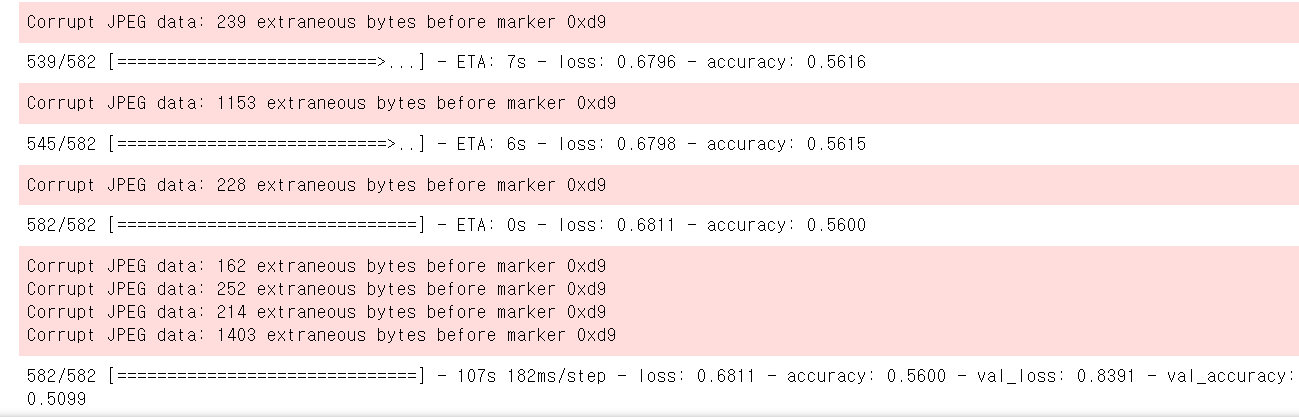
epoch:15
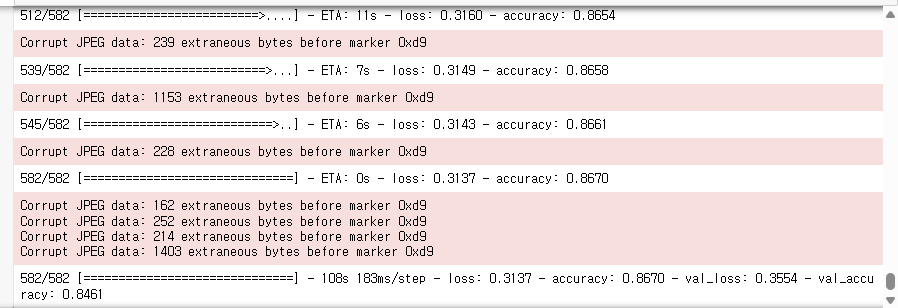

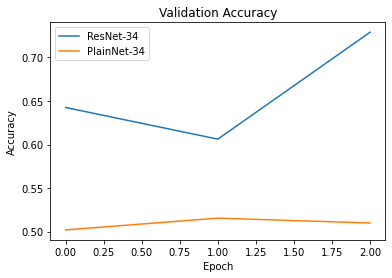

In [77]:
plt.plot(history_resnet34.history['val_accuracy'], label='ResNet-34')
plt.plot(history_plainnet34.history['val_accuracy'], label='PlainNet-34')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


epoch:3
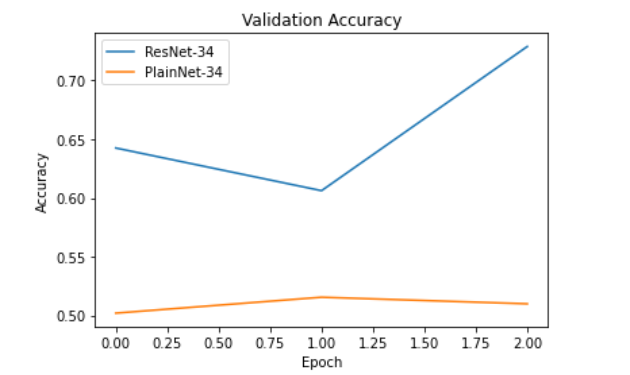

epoch:15

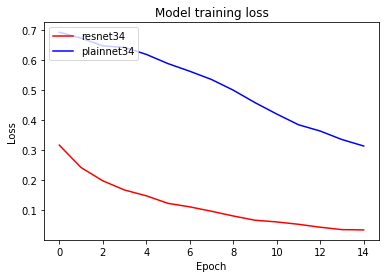

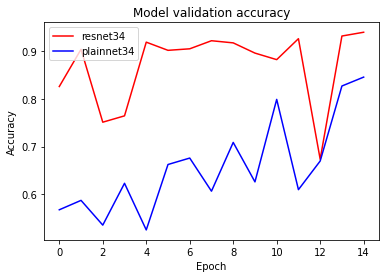

In [88]:
import matplotlib.pyplot as plt

plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_plainnet34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plainnet34'], loc='upper left')
plt.show()
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.plot(history_plainnet34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plainnet34'], loc='upper left')
plt.show()

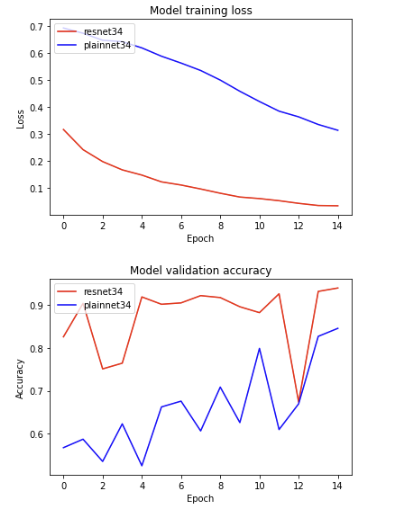

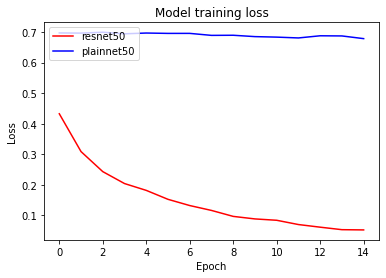

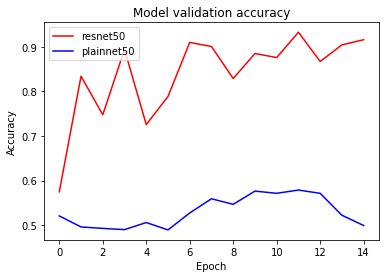

In [89]:
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plainnet50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plainnet50'], loc='upper left')
plt.show()
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plainnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plainnet50'], loc='upper left')
plt.show()

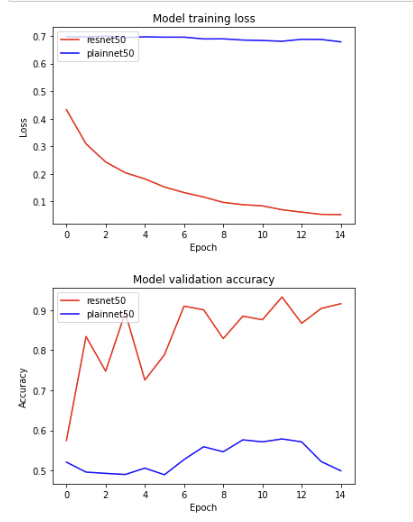